In [49]:
!jupyter nbconvert --to html "Split_Radix.ipynb"

[NbConvertApp] Converting notebook Split_Radix.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 5 image(s).
[NbConvertApp] Writing 589683 bytes to Split_Radix.html


# Split Radix

Esse notebook tem por objetivo implementar o algoritmo de cálculo de Transformada discreta de fourier Split Radix. Além disso, iremos comparar os resultados obtidos em sinal e tempo de execução com algoritmos padrão como DTF direta e o método do numpy. No entanto, antes de começar, vamos dar uma revisada nos outros métodos.

## 1. Relembrando a DFT

A DFT direta de um vetor $ x $ de tamanho $ N $ é:

$$
X[k] = \sum_{n=0}^{N-1} x[n]\;e^{-j 2\pi nk/N},\quad k=0,\ldots,N-1.
$$

Complexidade: $O(N^2)$.  
Usamos FFT para reduzir a \(O(N\log N)\).

---


## 2. O que o NumPy usa?

O `numpy.fft` baseia-se no **pocketfft** (desde NumPy 1.17),  
um algoritmo de FFT altamente otimizado em C/C++, que:
- Escolhe mixed-radix ou Bluestein conforme \(N\)
- Usa buffer in-place e otimizações de memoização

Veja https://numpy.org/doc/stable/reference/routines.fft.html  

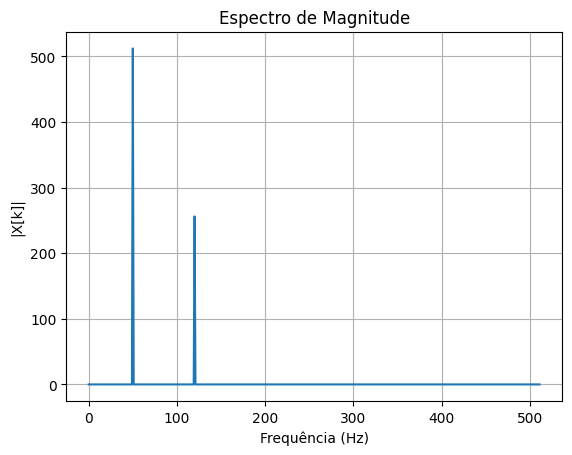

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Sinal de exemplo
Fs = 1024  # frequência de amostragem
t = np.linspace(0, 1, Fs, endpoint=False)
xA = np.sin(2*np.pi*50*t) + 0.5*np.sin(2*np.pi*120*t)

# FFT
XA = np.fft.fft(xA)
frequencies = np.fft.fftfreq(len(xA), 1/Fs)

# Visualização
plt.plot(frequencies[:Fs//2], np.abs(XA)[:Fs//2])
plt.title("Espectro de Magnitude")
plt.xlabel("Frequência (Hz)")
plt.ylabel("|X[k]|")
plt.grid()
plt.show()

## 3. Implementando a DFT direta
**Estratégia**: Avaliação direta da fórmula da DFT sem otimizações, utilizando multiplicações e somas complexas para cada frequência \( k \).

**Modelo Matemático**:  
Para um sinal discreto $ x[n] $ de tamanho $ N $, a DFT é definida como:  
$$
X[k] = \sum_{n=0}^{N-1} x[n] \cdot e^{-j \frac{2\pi}{N} kn}, \quad k = 0, 1, \dots, N-1
$$  
A transformada inversa (IDFT) é dada por:  
$$
x[n] = \frac{1}{N} \sum_{k=0}^{N-1} X[k] \cdot e^{j \frac{2\pi}{N} kn}
$$
**Complexidade**:  
- Cada $ X[k] $ requer $ N $ multiplicações e $ N-1 $ somas.  
- Para $ N $ pontos: $ O(N^2) $.  

**Limitações**:  
Ineficiente para $ N $ grande devido à explosão combinatória de operações.

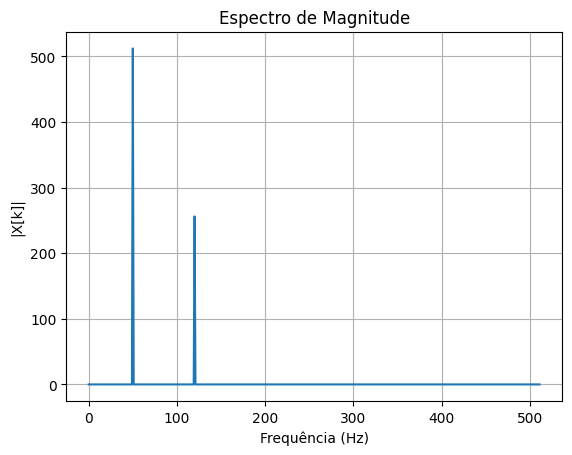

In [2]:
import numpy as np

def dft(x):
    N = len(x)
    X = np.zeros(N, dtype=complex)
    for k in range(N):
        for n in range(N):
            X[k] += x[n] * np.exp(-2j * np.pi * k * n / N)
    return X

XA = dft(xA)
plt.plot(frequencies[:Fs//2], np.abs(XA)[:Fs//2])
plt.title("Espectro de Magnitude")
plt.xlabel("Frequência (Hz)")
plt.ylabel("|X[k]|")
plt.grid()
plt.show()

## 📘 4. Implementação 3: FFT Iterativa (Bit-Reversal + Butterfly)
**Estratégia**:  
1. **Bit-Reversal**: Reorganiza os índices de entrada em ordem reversa de bits (ex: índice \( 6 = 110_2 \) → \( 011_2 = 3 \)).  
2. **Butterfly Iterativo**: Combina resultados em estágios sucessivos, evitando recursão.

**Modelo Matemático**:  
Para cada estágio $ s $ (tamanho do bloco $ 2s $):  
$$
\begin{aligned}
X_{\text{novo}}[k] &= X_{\text{antigo}}[k] + W_N^{m} \cdot X_{\text{antigo}}[k + s] \\
X_{\text{novo}}[k + s] &= X_{\text{antigo}}[k] - W_N^{m} \cdot X_{\text{antigo}}[k + s]
\end{aligned}
$$
onde $ m = k \mod s $.  

**Exemplo de Bit-Reversal para $ N=8 $**:
- Índice Original: 0 1 2 3 4 5 6 7
- Binário: 000 001 010 011 100 101 110 111
- Reverso: 000 100 010 110 001 101 011 111
- Índice Reverso: 0 4 2 6 1 5 3 7

**Complexidade**:  
- Bit-Reversal: $ O(N) $.  
- Butterfly: $ O(N \log N) $.  
- Total: $ O(N \log N) $.  

**Vantagem**: Eficiente em hardware (evita pilha de recursão).

In [3]:
def bit_reverse_indices(N):
    bits = int(np.log2(N))
    indices = np.arange(N)
    rev = indices.copy()
    for i in range(N):
        b = format(i, f'0{bits}b')[::-1]  # string reversed
        rev[i] = int(b, 2)
    return rev

def fft_iterative(x):
    N = len(x)
    if np.log2(N)%1 > 0:
        raise ValueError("Tamanho deve ser potência de 2")
    X = x.astype(complex)[bit_reverse_indices(N)]
    half = 1
    while half < N:
        phase = np.exp(-2j*np.pi*np.arange(half)/ (2*half))
        for k in range(0, N, 2*half):
            for n in range(half):
                a = X[k + n]
                b = X[k + n + half] * phase[n]
                X[k + n]     = a + b
                X[k + n + half] = a - b
        half *= 2
    return X

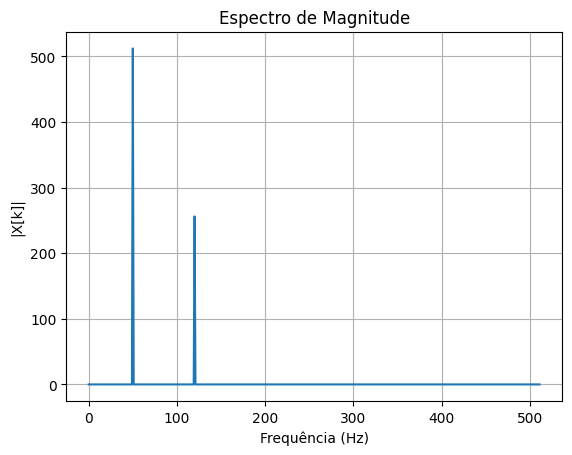

In [4]:
XA = fft_iterative(xA)
# Visualização
plt.plot(frequencies[:Fs//2], np.abs(XA)[:Fs//2])
plt.title("Espectro de Magnitude")
plt.xlabel("Frequência (Hz)")
plt.ylabel("|X[k]|")
plt.grid()
plt.show()

## 5. Implementação 2: Cooley-Tukey - FFT Recursiva Radix-2

Só funciona se $N$ for potência de 2.

**Estratégia**: Divide-and-conquer baseado na decomposição do sinal em componentes pares e ímpares, reduzindo o problema a sub-DFTs de tamanho $N/2 $.

**Modelo Matemático**:  
Se $ N = 2^m $, decomponha $ x[n] $ em:  
$$
x_{\text{par}}[m] = x[2m], \quad x_{\text{ímpar}}[m] = x[2m+1]
$$
A DFT é reescrita como:  
$$
X[k] = \underbrace{\sum_{m=0}^{N/2-1} x_{\text{par}}[m] \cdot e^{-j \frac{2\pi}{N/2} km}}_{\text{DFT dos pares}} + e^{-j \frac{2\pi}{N}k} \underbrace{\sum_{m=0}^{N/2-1} x_{\text{ímpar}}[m] \cdot e^{-j \frac{2\pi}{N/2} km}}_{\text{DFT dos ímpares}}
$$
**Fator de Fase (Twiddle Factor)**:  
$$
W_N^k = e^{-j \frac{2\pi}{N}k}
$$  

**Complexidade**:  
- Número de estágios: $ \log_2 N $.  
- Operações por estágio: $ O(N) $.  
- Total: $ O(N \log N) $.  

**Restrição**: $ N $ deve ser uma potência de 2.

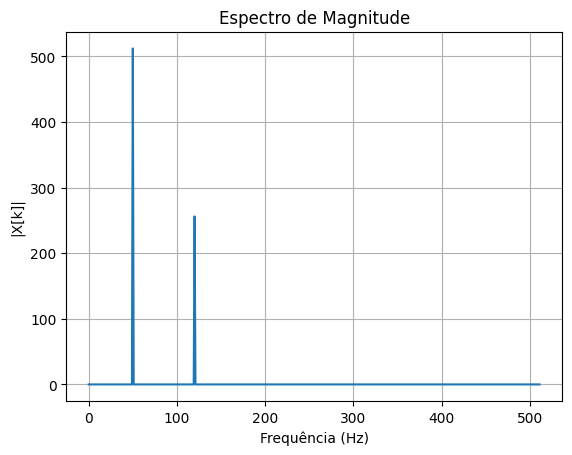

In [5]:
def fft_recursive(x):
    N = len(x)
    if N <= 1:
        return x.astype(complex)
    if N % 2 != 0:
        raise ValueError("Tamanho deve ser potência de 2")
    X_even = fft_recursive(x[::2])
    X_odd  = fft_recursive(x[1::2])
    factor = np.exp(-2j * np.pi * np.arange(N) / N)
    return np.concatenate([X_even + factor[:N//2]*X_odd,
                           X_even + factor[N//2:]*X_odd])

XA = fft_recursive(xA)
# Visualização
plt.plot(frequencies[:Fs//2], np.abs(XA)[:Fs//2])
plt.title("Espectro de Magnitude")
plt.xlabel("Frequência (Hz)")
plt.ylabel("|X[k]|")
plt.grid()
plt.show()

## 📘 6. Implementando Split-Radix FFT

### 1 Introdução  
O **Split-Radix FFT** combina as ideias dos algoritmos radix-2 e radix-4 para minimizar o número de operações em ponto flutuante. É especialmente eficiente quando $N$ é potência de dois.

---

### 2 Modelo Matemático  
Para $N=2^m$, escrevemos a DFT original  
$$
X[k] \;=\; \sum_{n=0}^{N-1} x[n]\,e^{-j2\pi nk/N},
$$  
e separamos em três sub-conjuntos:
1. **Índices pares**: $n=2r$ → DFT de tamanho $N/2$  
2. **Índices impares tipo 1**: $n=4r+1$ → DFT de tamanho $N/4$
3. **Índices impares tipo 3**: $n=4r+3$ → DFT de tamanho $N/4$

Chamando  
$$
E[k] = \sum_{r=0}^{N/2-1} x[2r]\,W_N^{2rk},\quad
O_1[k] = \sum_{r=0}^{N/4-1} x[4r+1]\,W_N^{(4r+1)k},\quad
O_3[k] = \sum_{r=0}^{N/4-1} x[4r+3]\,W_N^{(4r+3)k},
$$
onde $W_N = e^{-j2\pi/N}$. Então:
$$
\begin{cases}
X[k] = E[k] + W_N^k\,O_1[k] + W_N^{3k}\,O_3[k],\\[6pt]
X[k + N/2] = E[k] - \bigl[\,W_N^k\,O_1[k] + W_N^{3k}\,O_3[k]\bigr],\\[6pt]
X[k + N/4] = E[k + N/4] + j\,\bigl[\,W_N^k\,O_1[k] - W_N^{3k}\,O_3[k]\bigr],\\[6pt]
X[k + 3N/4] = E[k + N/4] - j\,\bigl[\,W_N^k\,O_1[k] - W_N^{3k}\,O_3[k]\bigr].
\end{cases}
$$

---

### 3 Estratégia de Implementação passo-a-passo  
1. **Base**: se $N=1$, retorne $x[0]$.  
2. **Recursão**:
   - Calcule FFT de $x[0],x[2],\dots$ → vetor $E$ (tamanho $N/2$).  
   - Calcule FFT de $x[1],x[5],x[9],\dots$ → vetor $O_1$ (tamanho $N/4$).  
   - Calcule FFT de $x[3],x[7],x[11],\dots$ → vetor $O_3$ (tamanho $N/4$).  
3. **Combine** $E,O_1,O_3$ conforme as fórmulas acima, usando pre-cálculo de  
   $\{W_N^k,\,W_N^{3k}\}$.  
4. **Return** vetor $X[0\ldots N-1]$.

---

### 4 Complexidade  
$$
T(N) = T(N/2) + 2\,T(N/4) + O(N)
\quad\Longrightarrow\quad
O(N\log N)
$$
Com custo aproximado de $4N\log_2 N - 6N + 8$operações reais.


In [6]:
import numpy as np
import time
import pandas as pd
import numba

# Exibe os resultados do numpy com precisão de 5 casas decimais para facilitar a comparação.
np.set_printoptions(precision=5, suppress=True)

# @numba.jit(nopython=True, cache=True)
def split_radix_fft(x):
    """
    Calcula a FFT usando o algoritmo Split-Radix (versão corrigida).
    O tamanho do sinal de entrada 'N' deve ser uma potência de 2.

    Parâmetros:
    x (np.array): O sinal de entrada.

    Retorna:
    np.array: O resultado da FFT.
    """
    N = len(x)

    if N <= 1:
        return x.astype(np.complex128)

    # A decomposição Split-Radix não se aplica para N=2.
    # Calculamos diretamente usando a borboleta do Radix-2.
    if N == 2:
        return np.array([x[0] + x[1], x[0] - x[1]], dtype=np.complex128)

    # Verifica se N é potência de 2 (restrição do algoritmo)
    if (N & (N - 1)) != 0:
        raise ValueError("O tamanho do sinal de entrada deve ser uma potência de 2.")

    # 1. Separação dos índices
    x_par = x[::2]
    x_impar1 = x[1::4]
    x_impar3 = x[3::4]

    # 2. Recursão
    E = split_radix_fft(x_par)
    O1 = split_radix_fft(x_impar1)
    O3 = split_radix_fft(x_impar3)

    # 3. Combinação dos resultados
    X = np.zeros(N, dtype=np.complex128)

    # Pré-cálculo dos fatores de torção (W_N^k e W_N^{3k})
    k = np.arange(N // 4)
    W_N_k = np.exp(-2j * np.pi * k / N)
    W_N_3k = np.exp(-2j * np.pi * 3 * k / N)

    # Combina O1 e O3
    O1_Wk = W_N_k * O1
    O3_W3k = W_N_3k * O3

    termo_soma = O1_Wk + O3_W3k
    termo_diff = O1_Wk - O3_W3k

    # Combina os resultados para formar o vetor X completo
    # O vetor E tem tamanho N/2. Usamos a primeira metade (0..N/4-1) e a segunda (N/4..N/2-1)
    E_primeira_metade = E[:N//4]
    E_segunda_metade = E[N//4:]

    # Intervalo k = 0, ..., N/4 - 1
    idx_p1_end = N // 4
    idx_p2_end = N // 2
    idx_p3_end = 3 * N // 4

    X[:idx_p1_end] = E_primeira_metade + termo_soma
    X[idx_p2_end:idx_p3_end] = E_primeira_metade - termo_soma
    X[idx_p1_end:idx_p2_end] = E_segunda_metade - 1j * termo_diff
    X[idx_p3_end:] = E_segunda_metade + 1j * termo_diff

    return X

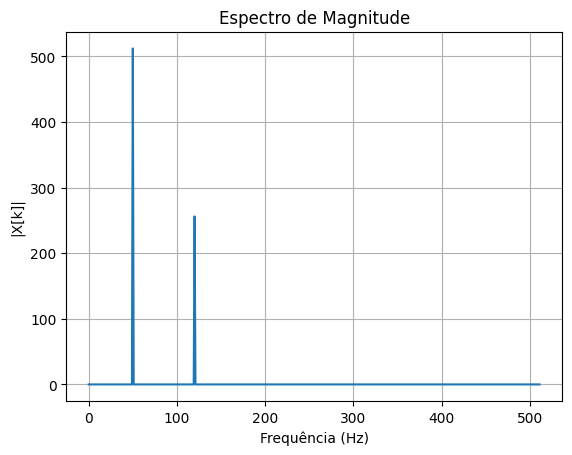

In [8]:
XA = split_radix_fft(xA)
plt.plot(frequencies[:Fs//2], np.abs(XA)[:Fs//2])
plt.title("Espectro de Magnitude")
plt.xlabel("Frequência (Hz)")
plt.ylabel("|X[k]|")
plt.grid()
plt.show()

## 📘 7. Benchmark Comparativo

Tendo validado que os métodos apresentam resultados semelhantes, vamos medir tempos de:
- DFT direta  
- FFT Split Radix (recursiva)
- `numpy.fft.fft`

Esse benchmark será feito de duas formas:

- Use `timeit` para cada um, em diferentes tamanhos $N$.
- Utilizando simplesmente o time antes e depois de executar o método

Além disso, uma validação extra será feita para garantir que as respostas estão dentro do valor esperado (o do numpy).

In [9]:
import timeit

def benchmark(func, x, repeats=3):
    stmt = f'func(x)'
    setup = f'from __main__ import func, x'
    return min(timeit.repeat(stmt, setup=setup, number=1, repeat=repeats))

for N in [64, 256, 1024]:
    x = np.random.randn(N)
    print(f"\nN = {N}")
    for func in [dft, split_radix_fft, fft_recursive, fft_iterative, np.fft.fft]:
        name = func.__name__
        try:
            t = benchmark(func, x)
            print(f"{name:15s}: {t:.4f} s")
        except Exception as e:
            print(f"{name:15s}: erro ({e})")


N = 64
dft            : 0.0072 s
split_radix_fft: 0.0011 s
fft_recursive  : 0.0013 s
fft_iterative  : 0.0004 s
fft            : 0.0000 s

N = 256
dft            : 0.1211 s
split_radix_fft: 0.0030 s
fft_recursive  : 0.0046 s
fft_iterative  : 0.0014 s
fft            : 0.0000 s

N = 1024
dft            : 1.8795 s
split_radix_fft: 0.0079 s
fft_recursive  : 0.0117 s
fft_iterative  : 0.0057 s
fft            : 0.0000 s


In [12]:
def realizar_benchmark(valores_N):
    """
    Executa a comparação de desempenho entre os três métodos de DFT.
    """
    resultados = []

    for N in valores_N:
        print(f"--- Iniciando teste para N = {N} ---")

        sinal_teste = np.random.rand(N) + 1j * np.random.rand(N)
        tempos = {'N': N}
        resultado_dft = None

        if N <= 4096:
            inicio = time.time()
            resultado_dft = dft(sinal_teste)
            fim = time.time()
            tempos['Direta (s)'] = fim - inicio
            print(f"Direta concluída em {tempos['Direta (s)']:.5f} segundos.")
        else:
            tempos['Direta (s)'] = float('inf')
            print("Direta ignorada para N > 4096 (muito lento).")

        inicio = time.time()
        resultado_srfft = split_radix_fft(sinal_teste)
        fim = time.time()
        tempos['Split-Radix (s)'] = fim - inicio
        print(f"Split-Radix concluída em {tempos['Split-Radix (s)']:.5f} segundos.")

        inicio = time.time()
        resultado_rfft = fft_recursive(sinal_teste)
        fim = time.time()
        tempos['Recursiva (s)'] = fim - inicio
        print(f"Recursiva concluída em {tempos['Recursiva (s)']:.5f} segundos.")

        inicio = time.time()
        resultado_ifft = fft_iterative(sinal_teste)
        fim = time.time()
        tempos['Iterativa (s)'] = fim - inicio
        print(f"Iterativa concluída em {tempos['Iterativa (s)']:.5f} segundos.")

        inicio = time.time()
        resultado_npfft = np.fft.fft(sinal_teste)
        fim = time.time()
        tempos['NumPy (s)'] = fim - inicio
        print(f"NumPy concluída em {tempos['NumPy (s)']:.5f} segundos.")

        erro_dft_str = "N/A"
        if resultado_dft is not None:
             erro_dft_str = "Correto" if np.allclose(resultado_dft, resultado_npfft) else "Incorreto"

        erro_srfft_str = "Correto" if np.allclose(resultado_srfft, resultado_npfft) else "Incorreto"
        erro_ifft_str = "Correto" if np.allclose(resultado_ifft, resultado_npfft) else "Incorreto"
        erro_rfft_str = "Correto" if np.allclose(resultado_rfft, resultado_npfft) else "Incorreto"


        print(f"Verificação de resultados para N={N} -> DFT Direta: {erro_dft_str}, Split-Radix: {erro_srfft_str},"
         + f"Recursiva: {erro_rfft_str}, Iterativa: {erro_ifft_str}\n")

        resultados.append(tempos)

    return pd.DataFrame(resultados).set_index('N')


# 5. Execução e Análise dos Resultados
# ------------------------------------
valores_N_teste = [128, 256, 512, 1024, 2048]

df_resultados = realizar_benchmark(valores_N_teste)

print("\n--- Tabela de Benchmark ---")
print("Tempos de execução em segundos:")
print(df_resultados)

--- Iniciando teste para N = 128 ---
Direta concluída em 0.02922 segundos.
Split-Radix concluída em 0.00114 segundos.
Recursiva concluída em 0.00129 segundos.
Iterativa concluída em 0.00060 segundos.
NumPy concluída em 0.00010 segundos.
Verificação de resultados para N=128 -> DFT Direta: Correto, Split-Radix: Correto,Recursiva: Correto, Iterativa: Correto

--- Iniciando teste para N = 256 ---
Direta concluída em 0.12656 segundos.
Split-Radix concluída em 0.00315 segundos.
Recursiva concluída em 0.00704 segundos.
Iterativa concluída em 0.00147 segundos.
NumPy concluída em 0.00007 segundos.
Verificação de resultados para N=256 -> DFT Direta: Correto, Split-Radix: Correto,Recursiva: Correto, Iterativa: Correto

--- Iniciando teste para N = 512 ---
Direta concluída em 0.48724 segundos.
Split-Radix concluída em 0.00441 segundos.
Recursiva concluída em 0.00555 segundos.
Iterativa concluída em 0.00240 segundos.
NumPy concluída em 0.00008 segundos.
Verificação de resultados para N=512 -> DFT D

## 8. Comparação gráfica das diferenças entre o Split Radix e o Numpy

Como vimos nesse notebook, o método abordado trás uma precisão boa comparada com o método direto e do numpy, que são os mais seguros. No entanto, nem todo método é perfeito, e manipuilação de float pode levar a alguns erros. Vamos observar a magnitude desses erros.

Calculando a FFT com NumPy...
Calculando a FFT com nossa função Split-Radix...


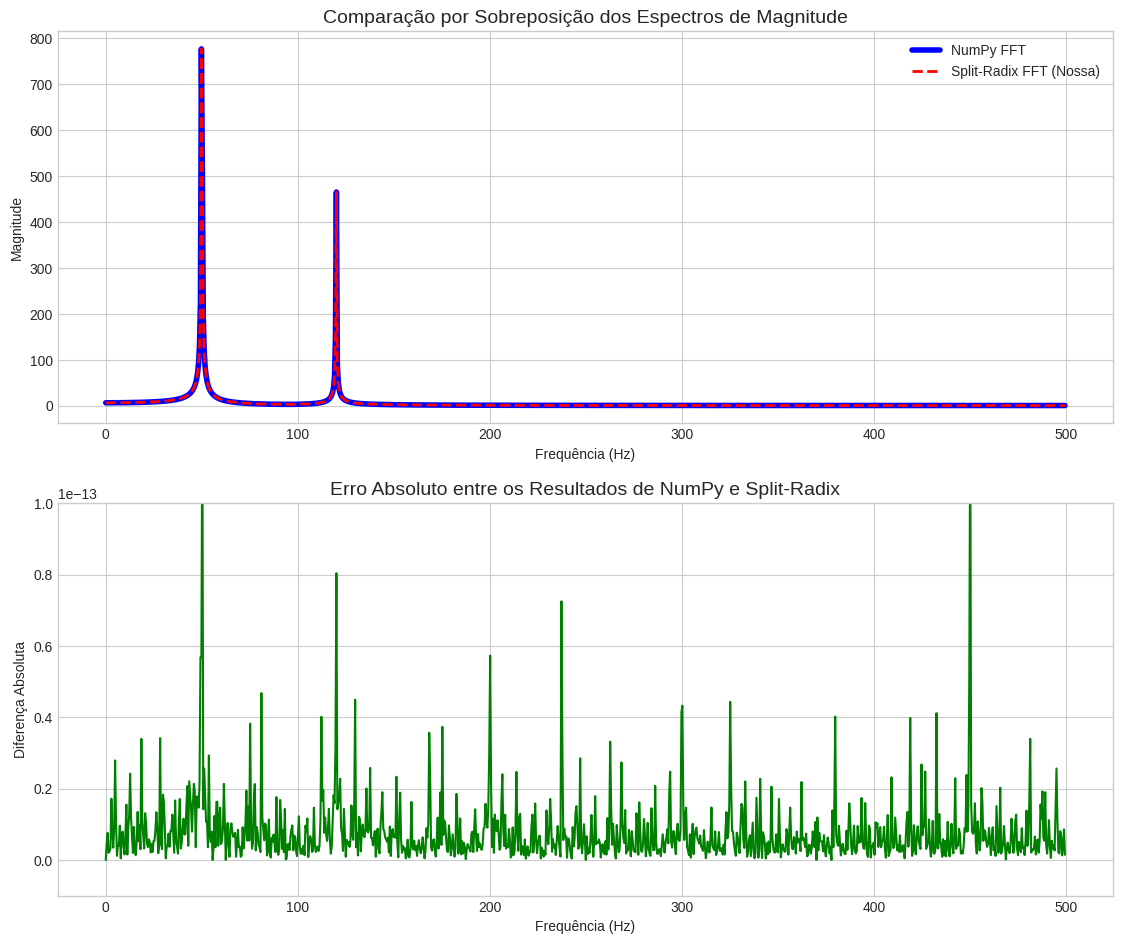

In [39]:
import matplotlib.pyplot as plt

N = 2048
fs = 1000
t = np.arange(N) / fs

sinal_tempo = np.sin(2*np.pi*50*t) + 0.5*np.sin(2*np.pi*120*t)

# --- Passo 2: Calcular a FFT usando os dois métodos ---
print("Calculando a FFT com NumPy...")
resultado_numpy = np.fft.fft(sinal_tempo)

print("Calculando a FFT com nossa função Split-Radix...")
resultado_sr = split_radix_fft(sinal_tempo)

# --- Passo 3: Preparar os dados para os gráficos ---
# Calcular as magnitudes de ambos os resultados
magnitude_numpy = np.abs(resultado_numpy)
magnitude_sr = np.abs(resultado_sr)

# Calcular o erro absoluto entre os dois vetores de resultado complexos
erro_absoluto = np.abs(resultado_numpy - resultado_sr)

# Preparar o eixo da frequência (apenas a parte positiva para visualização)
freqs = np.fft.fftfreq(N, d=1/fs)
freqs_positivas = freqs[:N//2]

magnitude_numpy_positiva = magnitude_numpy[:N//2]
magnitude_sr_positiva = magnitude_sr[:N//2]
erro_absoluto_positivo = erro_absoluto[:N//2]

# --- Passo 4: Gerar os gráficos de comparação ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, axs = plt.subplots(2, 1, figsize=(12, 10))
fig.tight_layout(pad=4.0)

# Gráfico 1: Sobreposição dos Espectros de Magnitude
axs[0].set_title('Comparação por Sobreposição dos Espectros de Magnitude', fontsize=14)
axs[0].plot(freqs_positivas, magnitude_numpy_positiva, label='NumPy FFT', color='blue', linewidth=4)
axs[0].plot(freqs_positivas, magnitude_sr_positiva, label='Split-Radix FFT (Nossa)', color='red', linestyle='--', linewidth=2)
axs[0].set_xlabel('Frequência (Hz)')
axs[0].set_ylabel('Magnitude')
axs[0].legend()
axs[0].grid(True)

# Gráfico 2: Erro Absoluto entre os dois métodos
axs[1].set_title('Erro Absoluto entre os Resultados de NumPy e Split-Radix', fontsize=14)
axs[1].plot(freqs_positivas, erro_absoluto_positivo, color='green')
axs[1].set_xlabel('Frequência (Hz)')
axs[1].set_ylabel('Diferença Absoluta')
axs[1].set_ylim(bottom=-1e-14, top=1e-13) # Ajusta o eixo Y para focar na magnitude do erro
axs[1].grid(True)

# Exibe a figura com os dois gráficos
plt.show()